# Time series forecasting with Imputation for Methane Emission Monthly data

# Importing libraries

In [2]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import plotly as py
warnings.filterwarnings("ignore")

# Reading Monthly data 

In [3]:
data = pd.read_excel("CONSOLIDATED DATASET MONTHLY.xlsx",sheet_name='2019-2021final')
# Check the first 5 elements of the dataframe
data.head()

,Month,ADM2_PCODE,ADM2_EN,ZONE_CODE,COUNT,AREA,MIN,MAX,RANGE,MEAN,STD,SUM
0,2019-01-01,BD4001,Bagerhat,1,3816.0,0.307940,1807.507202,1908.687622,101.180420,1858.995721,23.941344,7.093928e+06
1,2019-01-01,BD2003,Bandarban,2,4898.0,0.395254,1806.120483,1882.715576,76.595093,1843.522820,16.032945,9.029575e+06
2,2019-01-01,BD1004,Barguna,3,1420.0,0.114590,1814.506226,1936.939941,122.433716,1900.288210,33.386658,2.698409e+06
3,2019-01-01,BD1006,Barisal,4,2331.0,0.188105,1868.450806,1940.849976,72.399170,1887.722332,11.607219,4.400281e+06
4,2019-01-01,BD1009,Bhola,5,1905.0,0.153728,1878.400635,1950.949951,72.549316,1930.130305,27.223902,3.676898e+06


In [4]:
datanew=data.copy()
datanew.shape

(2304, 12)

In [5]:
datanew['month'] = pd.DatetimeIndex(datanew['Month']).month
datanew['year'] = pd.DatetimeIndex(datanew['Month']).year
dataSept = datanew[datanew['month'] == 9]
dataSept.head()

,Month,ADM2_PCODE,ADM2_EN,ZONE_CODE,COUNT,AREA,MIN,MAX,RANGE,MEAN,STD,SUM,month,year
512,2019-09-01,BD4001,Bagerhat,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2019
513,2019-09-01,BD2003,Bandarban,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2019
514,2019-09-01,BD1004,Barguna,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2019
515,2019-09-01,BD1006,Barisal,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2019
516,2019-09-01,BD1009,Bhola,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2019


In [6]:
dataSept.shape

(192, 14)

In [7]:
# Get a month with data
month = 9
year = 2019
dataJan = datanew[(datanew['month'] == month) & (datanew['year'] == year)]
janMnth = dataJan[["Month", "MEAN", "month", "year"]]

In [9]:
janMnth.head()

,Month,MEAN,month,year
512,2019-09-01,NaN,9,2019
513,2019-09-01,NaN,9,2019
514,2019-09-01,NaN,9,2019
515,2019-09-01,NaN,9,2019
516,2019-09-01,NaN,9,2019


###  Function to impute data for september by 2.2% than annual minimum based on literature so the model is forced to predict an increase during monsoons
(https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JG003740)

In [17]:
def informedImputation(df, percentage_CH4_inc):
    year = 2019
    while year < 2022:
        for district in range(64):
            # Get existing data for a given month and year per 
            zoneCode = float(district)
            # Get annual min mean for a given district
            minAnnualMean = df.loc[(df['year'] == year) & (df['ZONE_CODE'] == zoneCode), 'MEAN'].min()

            # Create synthetic MEAN Methane Emission data for Sept
            minAnnualMean += (minAnnualMean * percentage_CH4_inc)

            # Impute the mean with informed methane emission values basing on a percentage
            month = 9
            df.loc[(df['year'] == year) & (df['month'] == month) & (df['ZONE_CODE'] == zoneCode), 'MEAN'] = minAnnualMean
        year += 1
    
    return df

In [18]:
percentage_CH4_inc = 0.022
imputed_data = informedImputation(datanew, percentage_CH4_inc)
imputed_data.rename({'Month': 'ds'}, axis=1, inplace=True)
imputed_data.rename({'MEAN': 'y'}, axis=1, inplace=True)
imputed_data.head()

,ds,ADM2_PCODE,ADM2_EN,ZONE_CODE,COUNT,AREA,MIN,MAX,RANGE,y,STD,SUM,month,year
0,2019-01-01,BD4001,Bagerhat,1,3816.0,0.307940,1807.507202,1908.687622,101.180420,1858.995721,23.941344,7.093928e+06,1,2019
1,2019-01-01,BD2003,Bandarban,2,4898.0,0.395254,1806.120483,1882.715576,76.595093,1843.522820,16.032945,9.029575e+06,1,2019
2,2019-01-01,BD1004,Barguna,3,1420.0,0.114590,1814.506226,1936.939941,122.433716,1900.288210,33.386658,2.698409e+06,1,2019
3,2019-01-01,BD1006,Barisal,4,2331.0,0.188105,1868.450806,1940.849976,72.399170,1887.722332,11.607219,4.400281e+06,1,2019
4,2019-01-01,BD1009,Bhola,5,1905.0,0.153728,1878.400635,1950.949951,72.549316,1930.130305,27.223902,3.676898e+06,1,2019


In [19]:
month = 9
year = 2021
imputed_data[(datanew['year'] == year) & (datanew['month'] == month)].head()

,ds,ADM2_PCODE,ADM2_EN,ZONE_CODE,COUNT,AREA,MIN,MAX,RANGE,y,STD,SUM,month,year
2048,2021-09-01,BD4001,Bagerhat,1,NaN,NaN,NaN,NaN,NaN,1918.318318,NaN,NaN,9,2021
2049,2021-09-01,BD2003,Bandarban,2,NaN,NaN,NaN,NaN,NaN,1913.244710,NaN,NaN,9,2021
2050,2021-09-01,BD1004,Barguna,3,NaN,NaN,NaN,NaN,NaN,1940.005138,NaN,NaN,9,2021
2051,2021-09-01,BD1006,Barisal,4,NaN,NaN,NaN,NaN,NaN,1930.611181,NaN,NaN,9,2021
2052,2021-09-01,BD1009,Bhola,5,NaN,NaN,NaN,NaN,NaN,1938.155199,NaN,NaN,9,2021


In [20]:
imputed_data = imputed_data[["ds","COUNT", "y", "month", "year"]]
imputed_data.head()

,ds,COUNT,y,month,year
0,2019-01-01,3816.0,1858.995721,1,2019
1,2019-01-01,4898.0,1843.522820,1,2019
2,2019-01-01,1420.0,1900.288210,1,2019
3,2019-01-01,2331.0,1887.722332,1,2019
4,2019-01-01,1905.0,1930.130305,1,2019


## Imputation with Linear Interpolation

In [21]:
imputed_data2 = imputed_data.copy()

In [22]:
imputed_data2.shape

(2304, 5)

In [23]:
nul_data = pd.isnull(imputed_data2['y']) 
print('Missing: %d' % len(imputed_data2[nul_data]))
imputed_data2 = imputed_data2[["ds", "y"]]
imputed_data2.head()

Missing: 963


,ds,y
0,2019-01-01,1858.995721
1,2019-01-01,1843.522820
2,2019-01-01,1900.288210
3,2019-01-01,1887.722332
4,2019-01-01,1930.130305


In [24]:
# on our data, impute the missing values using rolling window method
imputed_data2['y']= imputed_data2['y'].interpolate(method='linear')

In [25]:
nul_data = pd.isnull(imputed_data2['y']) 
print('Missing: %d' % len(imputed_data2[nul_data]))

Missing: 0


# visualize the dataframe i.e. Methane emission

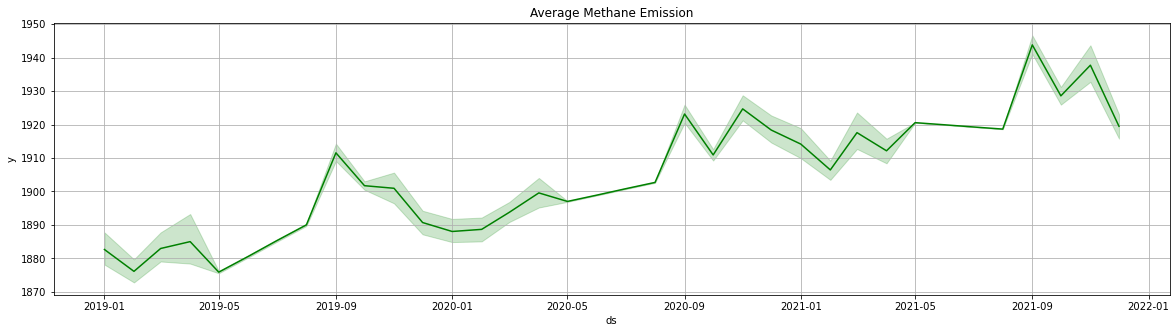

In [27]:
#Visualize the dataframe i.e. 
plt.figure(figsize=(20,5))
sns.lineplot(data=imputed_data2, x="ds", y="y", color='green')
plt.title("Average Methane Emission")
plt.grid(True)
plt.show()

## Imputation with KNN

In [86]:
imputed_data3 = imputed_data.copy()

In [87]:
nul_data = pd.isnull(imputed_data3['y']) 
print('Missing: %d' % len(imputed_data3[nul_data]))
imputed_data3 = imputed_data3[["ds", "COUNT", "y"]]
imputed_data3.head()

Missing: 963


,ds,COUNT,y
0,2019-01-01,3816.0,1858.995721
1,2019-01-01,4898.0,1843.522820
2,2019-01-01,1420.0,1900.288210
3,2019-01-01,2331.0,1887.722332
4,2019-01-01,1905.0,1930.130305


In [88]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# df = pd.DataFrame({'A':['a','b','a',np.nan,'a','b','c'] , 'B':[1,2,3,4,6,7,9] , 'C':['q','e',np.nan,'w','w','e','q']})  

mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df

In [89]:
cols_ = ['y']
#Define a subset of the dataset
df_knn = imputed_data3.filter(['COUNT','y'], axis=1).copy()
df_knn_imputed = imputation(df_knn, cols_)
df_knn_imputed.head()

,COUNT,y
0,3816,1858.995721
1,4898,1843.522820
2,1420,1900.288210
3,2331,1887.722332
4,1905,1930.130305


In [90]:
nul_data = pd.isnull(df_knn_imputed['y']) 
print('Missing: %d' % len(df_knn_imputed[nul_data]))

Missing: 0


In [91]:
#Separate dates for future plotting
train_dates = pd.to_datetime(imputed_data['ds'])
print(train_dates.tail()) #Check last few dates. 

2299   2021-12-01
2300   2021-12-01
2301   2021-12-01
2302   2021-12-01
2303   2021-12-01
Name: ds, dtype: datetime64[ns]


In [92]:
#Separate dates for future plotting
y = df_knn_imputed['y']
print(y.tail()) #Check last few dates. 

2299    1918.658255
2300    1904.396624
2301    1905.529753
2302    1916.621156
2303    1919.336884
Name: y, dtype: float64


In [93]:
# Join the dates and the means tobe predicted
means_df = pd.concat([train_dates, y], axis=1)
means_df.tail()

,ds,y
2299,2021-12-01,1918.658255
2300,2021-12-01,1904.396624
2301,2021-12-01,1905.529753
2302,2021-12-01,1916.621156
2303,2021-12-01,1919.336884


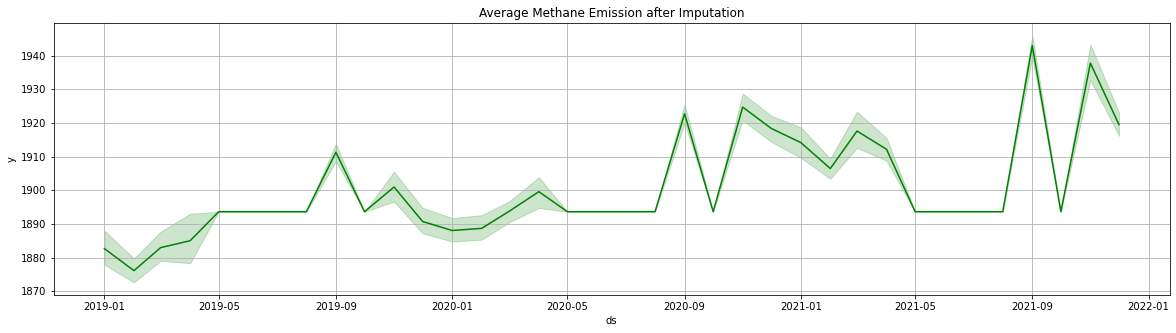

In [94]:
#Visualize the dataframe i.e. Methane emissions
plt.figure(figsize=(20,5))
sns.lineplot(data=means_df, x="ds", y="y", color='green')
plt.title("Average Methane Emission after Imputation")
plt.grid(True)
plt.show()

# Prediction & Forecast with Prophet 

### Using linear Interpolation Imputed Data

In [37]:
# model = Prophet()
# model.fit(imputed_data2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
li_model2 = Prophet(changepoint_prior_scale= 0.01, seasonality_prior_scale = 0.1)
li_model2.fit(imputed_data2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [96]:
future = li_model2.make_future_dataframe(periods= 24, freq='m')

In [97]:
future.tail(12)

,ds
48,2022-12-31
49,2023-01-31
50,2023-02-28
51,2023-03-31
52,2023-04-30
53,2023-05-31
54,2023-06-30
55,2023-07-31
56,2023-08-31
57,2023-09-30


In [98]:
forecast = li_model2.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
55,2023-07-31,1924.698130,1905.278484,1945.869749,1914.169668,1934.018894,2.647380,2.647380,2.647380,2.647380,2.647380,2.647380,0.0,0.0,0.0,1927.345510
56,2023-08-31,1924.748822,1930.132203,1967.386998,1913.264838,1934.529619,24.282897,24.282897,24.282897,24.282897,24.282897,24.282897,0.0,0.0,0.0,1949.031719
57,2023-09-30,1924.797879,1921.601201,1962.479600,1912.508883,1935.508050,17.765564,17.765564,17.765564,17.765564,17.765564,17.765564,0.0,0.0,0.0,1942.563442
58,2023-10-31,1924.848571,1902.279740,1944.845273,1911.633779,1936.413690,-0.995837,-0.995837,-0.995837,-0.995837,-0.995837,-0.995837,0.0,0.0,0.0,1923.852734
59,2023-11-30,1924.897628,1889.106871,1933.056519,1911.144552,1937.430268,-12.390578,-12.390578,-12.390578,-12.390578,-12.390578,-12.390578,0.0,0.0,0.0,1912.507050


In [99]:
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
55,2023-07-31,1927.345510,1905.278484,1945.869749
56,2023-08-31,1949.031719,1930.132203,1967.386998
57,2023-09-30,1942.563442,1921.601201,1962.479600
58,2023-10-31,1923.852734,1902.279740,1944.845273
59,2023-11-30,1912.507050,1889.106871,1933.056519


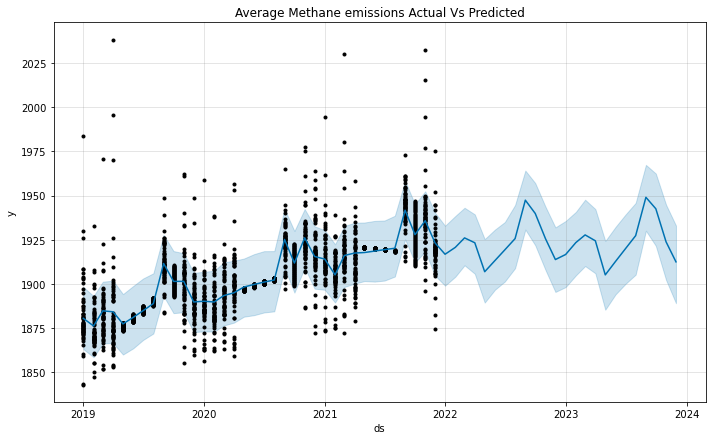

In [100]:
# Plot the graph of this data to get an understanding of how well forecast looks
li_model2.plot(forecast);
plt.title("Average Methane emissions Actual Vs Predicted")
plt.show()


In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# calculate MAE between expected and predicted values for next 60 mont
y_true = datanew['y'][:12].values
y_pred = forecast['yhat'][:12].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.3f' % mse)

MAE: 22.191
MSE: 724.641


# Actual Vs Predicted

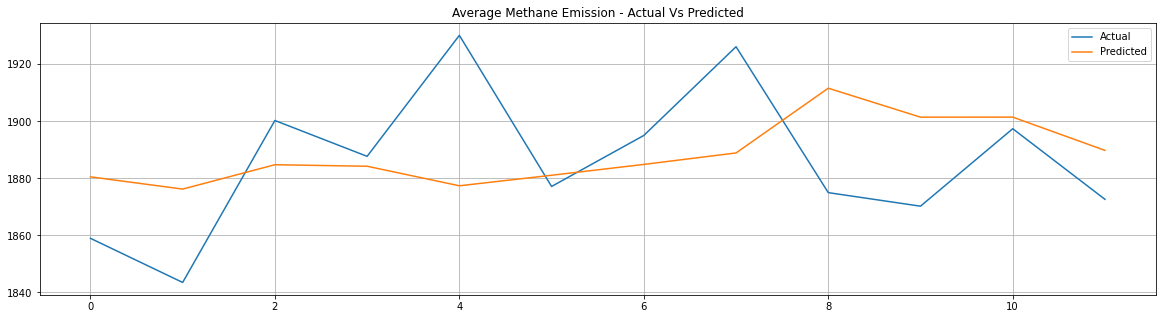

In [102]:
plt.figure(figsize=(20,5))
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Average Methane Emission - Actual Vs Predicted")
plt.grid(True)
plt.legend()
plt.show()

### Using KNN Imputed Data

In [131]:
model = Prophet()
model.fit(means_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [132]:
future = model.make_future_dataframe(periods= 24, freq='m')

In [133]:
future.tail(12)

,ds
48,2022-12-31
49,2023-01-31
50,2023-02-28
51,2023-03-31
52,2023-04-30
53,2023-05-31
54,2023-06-30
55,2023-07-31
56,2023-08-31
57,2023-09-30


In [134]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
55,2023-07-31,1967.638324,1773.283717,2168.729785,1771.745478,2169.041387,-2.792789,-2.792789,-2.792789,-2.792789,-2.792789,-2.792789,0.0,0.0,0.0,1964.845535
56,2023-08-31,1970.203911,1764.076612,2183.848122,1761.402204,2183.976329,-1.024588,-1.024588,-1.024588,-1.024588,-1.024588,-1.024588,0.0,0.0,0.0,1969.179323
57,2023-09-30,1972.686736,1766.413165,2220.369880,1751.930212,2203.645078,16.011505,16.011505,16.011505,16.011505,16.011505,16.011505,0.0,0.0,0.0,1988.698241
58,2023-10-31,1975.252323,1739.141482,2224.832880,1736.389483,2218.234980,2.131923,2.131923,2.131923,2.131923,2.131923,2.131923,0.0,0.0,0.0,1977.384246
59,2023-11-30,1977.735148,1711.142205,2237.455365,1720.308971,2238.440052,-3.613362,-3.613362,-3.613362,-3.613362,-3.613362,-3.613362,0.0,0.0,0.0,1974.121786


In [135]:
forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
55,2023-07-31,1964.845535,1773.283717,2168.729785
56,2023-08-31,1969.179323,1764.076612,2183.848122
57,2023-09-30,1988.698241,1766.413165,2220.369880
58,2023-10-31,1977.384246,1739.141482,2224.832880
59,2023-11-30,1974.121786,1711.142205,2237.455365


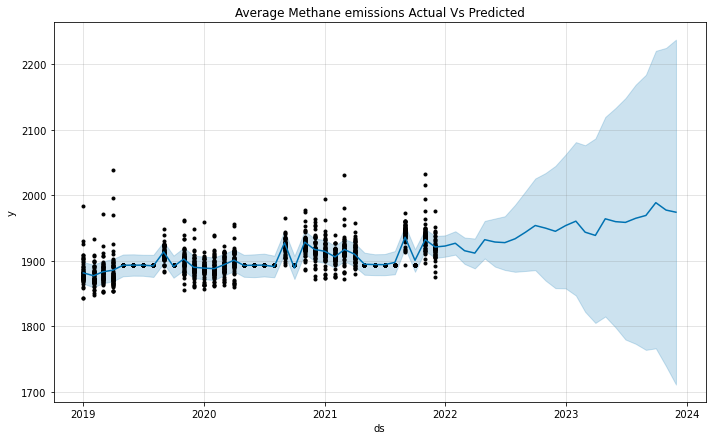

In [136]:
# Plot the graph of this data to get an understanding of how well forecast looks
model.plot(forecast);
plt.title("Average Methane emissions Actual Vs Predicted")
plt.show()

Mean Absolute Error (MAE) measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# calculate MAE between expected and predicted values for next 60 mont
y_true = datanew['y'][:12].values
y_pred = forecast['yhat'][:12].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 20.523


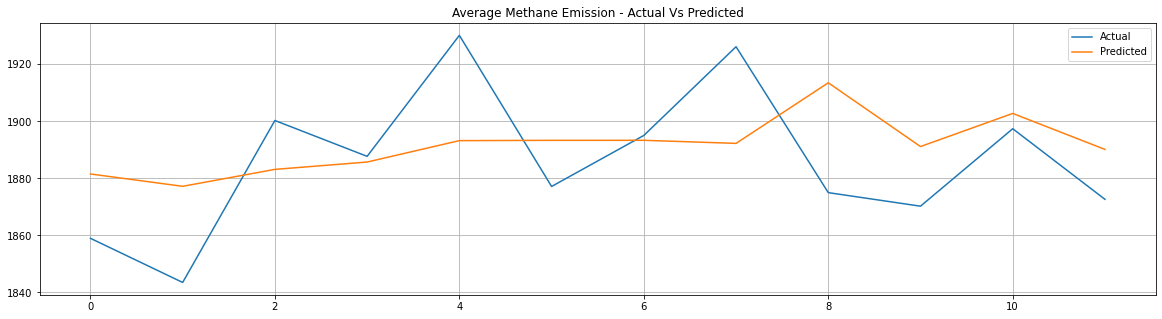

In [137]:
plt.figure(figsize=(20,5))
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Average Methane Emission - Actual Vs Predicted")
plt.grid(True)
plt.legend()
plt.show()

## Cross Validation

In [113]:
from fbprophet.diagnostics import cross_validation

In [114]:
df_cv = cross_validation(model, initial='500 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-06-04 00:00:00 and 2020-12-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [115]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-01,1898.976587,1881.426006,1916.638822,1893.621401,2020-06-04
1,2020-07-01,1898.976587,1882.154852,1917.372352,1893.621401,2020-06-04
2,2020-07-01,1898.976587,1881.416819,1916.382042,1893.621401,2020-06-04
3,2020-07-01,1898.976587,1882.234026,1916.106238,1893.621401,2020-06-04
4,2020-07-01,1898.976587,1882.073235,1916.037479,1893.621401,2020-06-04


In [117]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,58 days,174.409963,13.206436,7.811054,0.004077,0.001795,0.869281
1,62 days,314.149566,17.724265,12.861199,0.006728,0.004153,0.641748
2,89 days,338.453554,18.397107,15.032044,0.007844,0.006846,0.614379
3,90 days,390.438881,19.759526,14.189874,0.007369,0.005491,0.710069
4,119 days,238.967076,15.458560,7.543413,0.003907,0.001260,0.877859


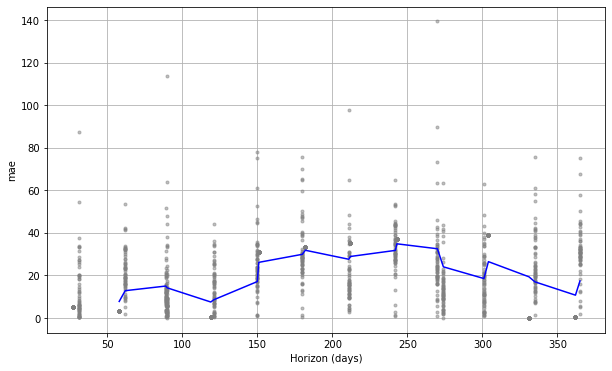

In [119]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

### Setting cutoff points

In [120]:
cutoffs = pd.to_datetime(['2020-06-04'])
df_cv2 = cross_validation(model, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/1 [00:00<?, ?it/s]

In [121]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-01,1898.976587,1881.426006,1916.638822,1893.621401,2020-06-04
1,2020-07-01,1898.976587,1882.154852,1917.372352,1893.621401,2020-06-04
2,2020-07-01,1898.976587,1881.416819,1916.382042,1893.621401,2020-06-04
3,2020-07-01,1898.976587,1882.234026,1916.106238,1893.621401,2020-06-04
4,2020-07-01,1898.976587,1882.073235,1916.037479,1893.621401,2020-06-04


In [122]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,58 days,174.409963,13.206436,7.811054,0.004077,0.001795,0.869281
1,62 days,314.149566,17.724265,12.861199,0.006728,0.004153,0.641748
2,89 days,338.453554,18.397107,15.032044,0.007844,0.006846,0.614379
3,90 days,390.438881,19.759526,14.189874,0.007369,0.005491,0.710069
4,119 days,238.967076,15.458560,7.543413,0.003907,0.001260,0.877859


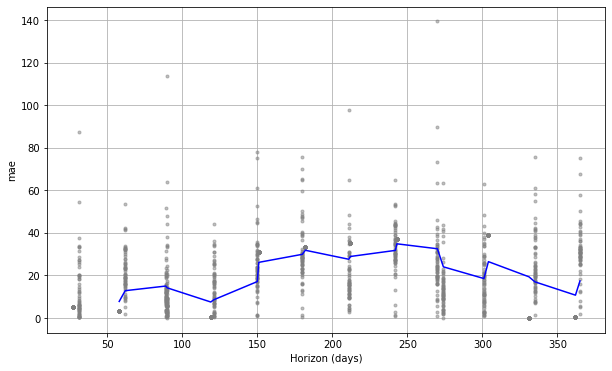

In [124]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

### Assist in Hyperparameter tuning for getting best parameters of the model

In [125]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mae = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(imputed_data2)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = mae
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001BD74532400>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001BD7500CD30>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001BD743DC970>
INFO:fbprophet:Disabling 

    changepoint_prior_scale  seasonality_prior_scale       mae
0                     0.001                     0.01  2.466557
1                     0.001                     0.10  4.349630
2                     0.001                     1.00  2.444919
3                     0.001                    10.00  2.686623
4                     0.010                     0.01  4.355303
5                     0.010                     0.10  2.748278
6                     0.010                     1.00  1.676000
7                     0.010                    10.00  3.347410
8                     0.100                     0.01  4.443374
9                     0.100                     0.10  4.124327
10                    0.100                     1.00  4.851871
11                    0.100                    10.00  4.632755
12                    0.500                     0.01  3.360278
13                    0.500                     0.10  5.662113
14                    0.500                     1.00  5

In [126]:
best_params = all_params[np.argmin(mae)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


In [127]:
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-06-04 00:00:00 and 2020-12-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

In [128]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-01,1898.976587,1882.483792,1915.744318,1893.621401,2020-06-04
1,2020-07-01,1898.976587,1880.633436,1915.433128,1893.621401,2020-06-04
2,2020-07-01,1898.976587,1880.792717,1916.795180,1893.621401,2020-06-04
3,2020-07-01,1898.976587,1881.491051,1916.837989,1893.621401,2020-06-04
4,2020-07-01,1898.976587,1880.004516,1917.584208,1893.621401,2020-06-04


In [129]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,58 days,174.409963,13.206436,7.811054,0.004077,0.001795,0.869281
1,62 days,314.149566,17.724265,12.861199,0.006728,0.004153,0.648284
2,89 days,338.453554,18.397107,15.032044,0.007844,0.006846,0.620915
3,90 days,390.438881,19.759526,14.189874,0.007369,0.005491,0.719158
4,119 days,238.967076,15.458560,7.543413,0.003907,0.001260,0.884395


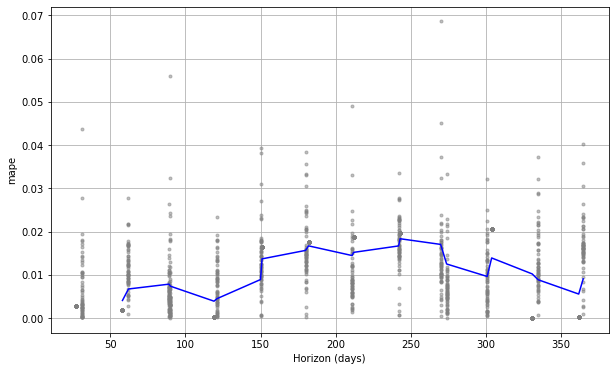

In [130]:
fig = plot_cross_validation_metric(df_cv, metric='mape')